In [1]:
# from model3d import Discriminator

# netD = Discriminator(1)

In [2]:
# import torch
# data = torch.randn(4,1,32,32,32)
# t = torch.randint(0, 4, (data.size(0),))
# out = netD(data, t)

torch.Size([4, 64, 32, 32, 32])
torch.Size([4, 64, 16, 16, 16])
torch.Size([4, 128, 16, 16, 16])
torch.Size([4, 128, 8, 8, 8])
torch.Size([4, 256, 8, 8, 8])
torch.Size([4, 256, 4, 4, 4])
torch.Size([4, 512, 4, 4, 4])
torch.Size([4, 512, 2, 2, 2])
torch.Size([4, 1])


In [1]:
import torch
import numpy as np

beta_min = 0.1
beta_max = 20
num_timesteps = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def var_func_vp(t, beta_min, beta_max):
    # Introduce noise more slowly over the timesteps
    # Change the rate of growth of t from quadratic to a higher power to slow down the noise addition
    beta_t = beta_min + (beta_max - beta_min) * (t ** 4)  # Use t to the power of 4 for an even slower increase
    
    # Calculate the variance using this slower beta_t schedule
    log_mean_coeff = -0.25 * t ** 2 * (beta_t - beta_min) - 0.5 * t * beta_min
    var = 1. - torch.exp(2. * log_mean_coeff)
    return var



def extract(input, t, shape):
    # Directly index input with t, no need for gather
    out = input[t].to(device)
    # No need for reshaping as we will use broadcasting
    return out

def get_sigma_schedule(num_timesteps, beta_min, beta_max, device):
    t = np.linspace(0, 1, num_timesteps + 1, dtype=np.float64)
    t = torch.from_numpy(t).to(device)
    
    var = var_func_vp(t, beta_min, beta_max)
    alpha_bars = 1.0 - var
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]
    
    first = torch.tensor([1e-8], device=device)
    betas = torch.cat((first, betas), dim=0)
    sigmas = torch.sqrt(betas)
    a_s = torch.sqrt(1 - betas)
    return sigmas, a_s, betas

sigmas, a_s, _ = get_sigma_schedule(num_timesteps, beta_min, beta_max, device=device)
a_s_cum = torch.cumprod(a_s, dim=0)
sigmas_cum = torch.sqrt(1 - a_s_cum ** 2)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    
    a_s_cum_t = extract(a_s_cum, t, x_start.shape) # Now directly indexed
    sigmas_cum_t = extract(sigmas_cum, t, x_start.shape) # Now directly indexed
    
    # Use broadcasting instead of explicit reshaping
    x_t = a_s_cum_t * x_start + sigmas_cum_t * noise
    return x_t


In [21]:
sr_slice = torch.rand(4,1,32,32,32).to(device)
hr_slice = torch.rand(4,1,32,32,32).to(device)
#t = torch.randint(0, num_timesteps, (hr_slice.size(0),), device=device)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#gt = np.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/3rd_yr/diffusion.py/result/2DOWN/result_2downT1000volume_inf.npy")
gt = np.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/3rd_yr/diffusion.py/result/real_results/diffGan_volume118528_inf.npy")   
#gt = np.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/3rd_yr/diffusion.py/result/real_results/baseGan_volume118528_gt.npy")   

idx = 80
hr_sample = torch.tensor(gt[:,idx,:])




/var/folders/54/9cg_cvqx0kz6lt4byw6bjmm80000gn/T/ipykernel_43209/2581635714.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_start = torch.tensor(hr_sample).to(device)


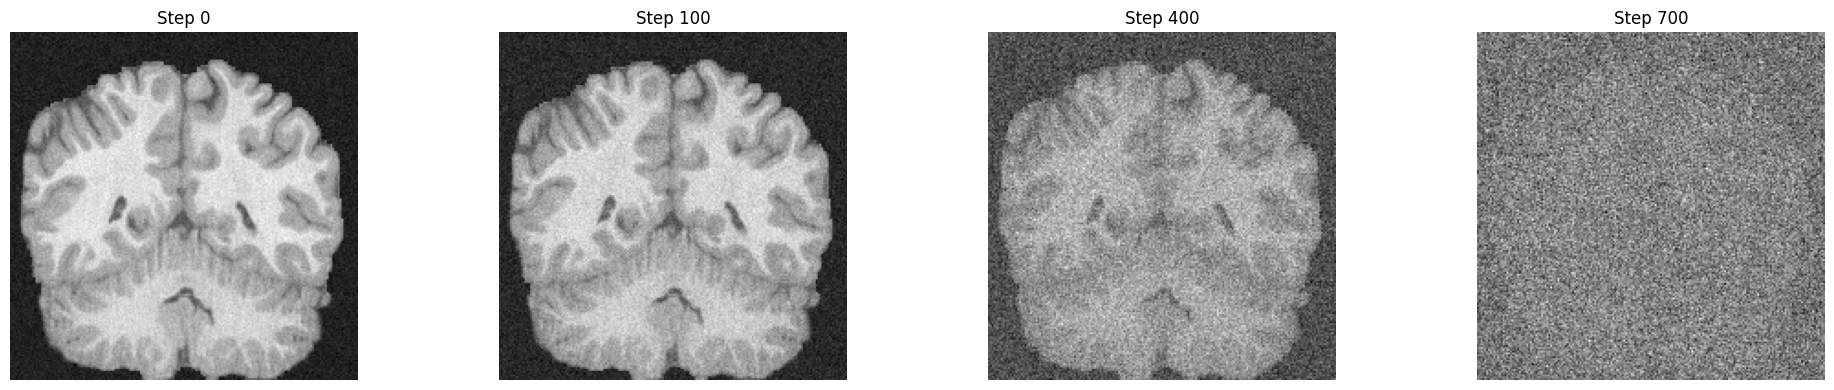

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Assuming `img` is already loaded and is a 2D tensor of shape [240, 240]

# Initialize parameters as before

# Load an example image
#torch tensor
x_start = torch.tensor(hr_sample).to(device)
#hr_sample = hr_sample[25:215,10:200]
x_start = x_start[25:215,10:200]
# Generate the diffusion sequence
# num_images_to_generate = 10  # Number of images in the diffusion sequence
timesteps = torch.tensor([0, 100, 400,700])
# print(timesteps)
diffusion_sequence = [q_sample(x_start, t+100) for t in timesteps]

# Since the images are 2D, we directly convert them to numpy for plotting, without assuming an extra dimension
diffusion_sequence_np = [x.cpu().numpy() for x in diffusion_sequence]

# Plot the sequence of images
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axs, diffusion_sequence_np)):
    #rotate the image
    img = np.rot90(img, k=1)
    ax.imshow(img, cmap='gray')  # Use gray colormap for grayscale images
    ax.axis('off')
    ax.set_title(f'Step {timesteps[i].item()}')
plt.tight_layout()
plt.show()


In [21]:
def calc_mean_var_mri():
    lr_file = "/Users/youngwoojung/Documents/Research_Internship/SEResUnet/BraTS/data/T1w/lr_norm.nii.gz"
    lst = []
    lst.append((nib.load(lr_file).get_fdata()))
    #plot the image     
    
    lst = np.array(lst)
    print(np.mean(lst), np.std(lst))
    return True
calc_mean_var_mri()

NameError: name 'nib' is not defined

(256, 256, 181)
(181, 256)


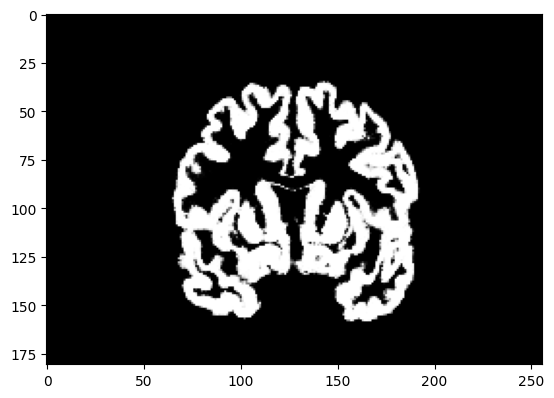

In [4]:
# #VSD.Brain.XX.O.MR_T1.824.mha

# from medpy.io import load

# image_data, image_header = load('/Users/youngwoojung/Documents/Research_Internship/SEResUnet/VSD.Brain.XX.O.MR_T1.878.mha')
# middle_slice = image_data[:, 150, :]
# middle_slice = np.rot90(middle_slice, 1)

# # Use matplotlib to display the image
# plt.imshow(middle_slice, cmap='gray')  # 'gray' colormap for grayscale images
# plt.show()
img = nib.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/BraTS/c1VSD.Brain.XX.O.MR_T1.878.nii")
print(img.shape)
affine = img.affine
img = img.get_fdata().astype(np.float32)[:,100,:]
#rotte the image
img = np.rot90(img, 1)
#show img
print(img.shape)
plt.imshow(img, cmap='gray')

In [16]:
# import nibabel as nib
# from nibabel.processing import resample_from_to

# # Load your image (assuming it's in NIfTI format)
# original_img = nib.load('/Users/youngwoojung/Documents/Research_Internship/SEResUnet/VSD.Brain.XX.O.MR_T1.878.nii')

# # Create a new affine for the target image
# new_affine = original_img.affine
# new_affine[0, 0] = original_img.header.get_zooms()[0]
# new_affine[1, 1] = original_img.header.get_zooms()[1]
# new_affine[2, 2] = original_img.header.get_zooms()[2] * (original_img.shape[2] / 256.0)

# # Create a target image with desired dimensions (256,256,256)
# target_img = nib.Nifti1Image(np.zeros((256, 256, 256)), new_affine)

# # Resample the original image to the target image
# resampled_img = resample_from_to(original_img, target_img)

# # Save the resampled image
# nib.save(resampled_img, '/Users/youngwoojung/Documents/Research_Internship/SEResUnet/VSD.Brain.XX.O.MR_T1.878.nii_resampled_image.nii')


(254, 229, 179)
(254, 229, 179)


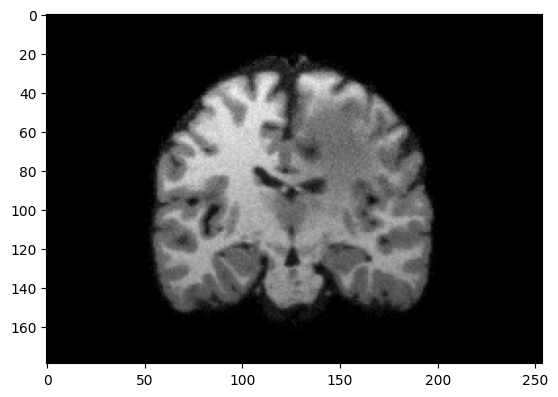

In [34]:
#/Users/youngwoojung/Documents/Research_Internship/SEResUnet/lr_norm.nii.gz
img = nib.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/BraTS/data/T1w/T1w_acpc_dc_restore_brain.nii.gz")
img_lr = nib.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/BraTS/data/T1w/lr_norm.nii.gz")
print(img.shape)
print(img_lr.shape)
affine = img.affine
img = img.get_fdata().astype(np.float32)[:,100,:]
#rotte the image
img = np.rot90(img, 1)
#show img

plt.imshow(img, cmap='gray')

In [43]:
from scipy import io

mat_file = io.loadmat('/Users/youngwoojung/Documents/Research_Internship/SEResUnet/spm_seg_batch.mat')

In [44]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan  6 18:05:06 2021',
 '__version__': '1.0',
 '__globals__': [],
 'matlabbatch': array([[array([[(array([[(array([[(array([[(array([[(array([[array(['~/test.nii'], dtype='<U10')]], dtype=object), array([[0.001]]), array([[60]], dtype=uint8), array([[0, 0]], dtype=uint8))]],
                                               dtype=[('vols', 'O'), ('biasreg', 'O'), ('biasfwhm', 'O'), ('write', 'O')]), array([[(array(['/share/apps/cmic/spm-12/tpm/TPM.nii,1'], dtype='<U37'), array([[1]], dtype=uint8), array([[1, 0]], dtype=uint8), array([[0, 0]], dtype=uint8)),
                                                 (array(['/share/apps/cmic/spm-12/tpm/TPM.nii,2'], dtype='<U37'), array([[1]], dtype=uint8), array([[1, 0]], dtype=uint8), array([[0, 0]], dtype=uint8)),
                                                 (array(['/share/apps/cmic/spm-12/tpm/TPM.nii,3'], dtype='<U37'), array([[2]], dtype=uint8), array([[1, 0]], dtype=u

(256, 256, 256)
(256, 256)


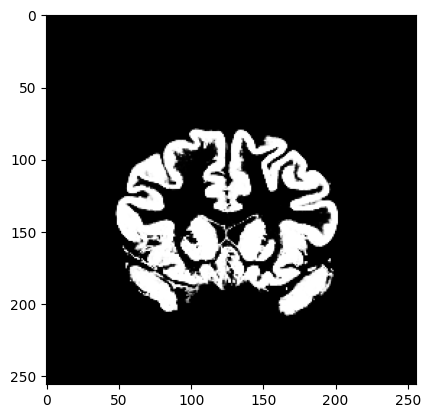

In [47]:
img = nib.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/c1T1brain.nii")
print(img.shape)
affine = img.affine
img = img.get_fdata().astype(np.float32)[:,180,:]
#rotte the image
img = np.rot90(img, 1)
#show img
print(img.shape)
plt.imshow(img, cmap='gray')

(256, 256, 256)
(256, 256)


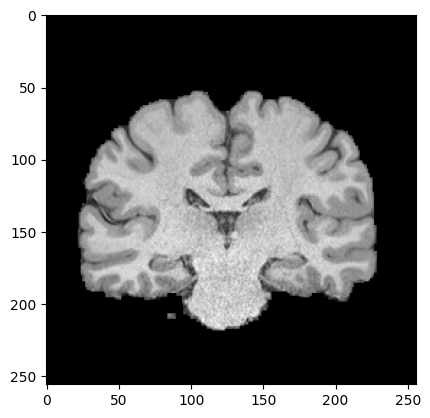

In [27]:
#/Users/youngwoojung/Documents/Research_Internship/SEResUnet/T1w_acpc_dc_restore_brain.nii.gz
img = nib.load("/Users/youngwoojung/Documents/Research_Internship/SEResUnet/T1w_acpc_dc_restore_brain.nii.gz")
print(img.shape)
affine = img.affine
img = img.get_fdata().astype(np.float32)[:,120,:]
#rotte the image
img = np.rot90(img, 1)
#show img
print(img.shape)
plt.imshow(img, cmap='gray')

In [11]:
beta_min = 0.1
beta_max = 20
num_timesteps = 600
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def var_func_vp(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    var = 1. - torch.exp(2. * log_mean_coeff)
    return var

def extract(input, t, shape):
    print("input", input.shape)
    out = torch.gather(input, 0, t)
    print("out", out.shape)
    reshape = [shape[0]] + [1] * (len(shape) - 1)
    print("reshape", reshape)
    out = out.reshape(*reshape)

    return out


def get_sigma_schedule(num_timesteps, beta_min, beta_max, device):
    n_timestep = num_timesteps
    beta_min = beta_min
    beta_max = beta_max
    eps_small = 1e-3
   
    t = np.arange(0, n_timestep + 1, dtype=np.float64)
    t = t / n_timestep
    t = torch.from_numpy(t) * (1. - eps_small) + eps_small
    
    var = var_func_vp(t, beta_min, beta_max)
    alpha_bars = 1.0 - var
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]
    
    first = torch.tensor(1e-8)
    betas = torch.cat((first[None], betas)).to(device)
    betas = betas.type(torch.float32)
    sigmas = betas**0.5
    a_s = torch.sqrt(1-betas)
    return sigmas, a_s, betas

sigmas, a_s, _ = get_sigma_schedule(num_timesteps, beta_min, beta_max, device=device)
a_s_cum = np.cumprod(a_s.cpu())
sigmas_cum = np.sqrt(1 - a_s_cum ** 2)

a_s_cum = a_s_cum.to(device)
sigmas_cum = sigmas_cum.to(device)
#x_start is the real data (lr_data)
def q_sample(x_start, t, *, noise=None):
    """
    Diffuse the data (t == 0 means diffused for t step)
    """
    if noise is None:
      noise = torch.randn_like(x_start).to(device)
      
    x_t = extract(a_s_cum, t, x_start.shape) * x_start + \
          extract(sigmas_cum, t, x_start.shape) * noise
    
    return x_t

In [12]:
print(sigmas.shape)
print("sigmas", sigmas)
print("a_s", a_s)

torch.Size([601])
sigmas tensor([1.0000e-04, 1.5073e-02, 1.6803e-02, 1.8371e-02, 1.9815e-02, 2.1161e-02,
        2.2426e-02, 2.3623e-02, 2.4763e-02, 2.5852e-02, 2.6897e-02, 2.7903e-02,
        2.8874e-02, 2.9813e-02, 3.0724e-02, 3.1608e-02, 3.2468e-02, 3.3306e-02,
        3.4123e-02, 3.4921e-02, 3.5701e-02, 3.6465e-02, 3.7213e-02, 3.7945e-02,
        3.8665e-02, 3.9370e-02, 4.0064e-02, 4.0745e-02, 4.1416e-02, 4.2075e-02,
        4.2725e-02, 4.3364e-02, 4.3995e-02, 4.4616e-02, 4.5229e-02, 4.5833e-02,
        4.6430e-02, 4.7019e-02, 4.7601e-02, 4.8175e-02, 4.8743e-02, 4.9305e-02,
        4.9860e-02, 5.0408e-02, 5.0951e-02, 5.1488e-02, 5.2020e-02, 5.2546e-02,
        5.3067e-02, 5.3583e-02, 5.4094e-02, 5.4600e-02, 5.5101e-02, 5.5598e-02,
        5.6090e-02, 5.6578e-02, 5.7062e-02, 5.7542e-02, 5.8018e-02, 5.8490e-02,
        5.8958e-02, 5.9422e-02, 5.9883e-02, 6.0340e-02, 6.0794e-02, 6.1244e-02,
        6.1691e-02, 6.2135e-02, 6.2576e-02, 6.3013e-02, 6.3448e-02, 6.3879e-02,
        6.4308e

torch.Size([1, 1, 256, 256])
tensor(0)
input torch.Size([601])
out torch.Size([])
reshape [1, 1, 1, 1]
input torch.Size([601])
out torch.Size([])
reshape [1, 1, 1, 1]
torch.Size([1, 1, 256, 256])


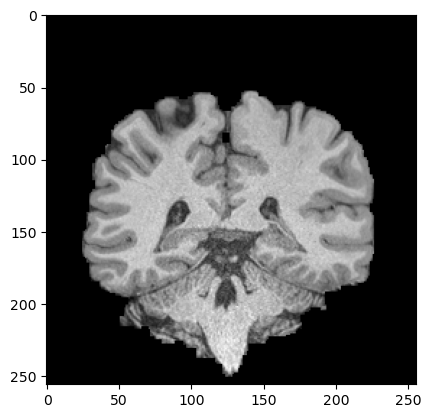

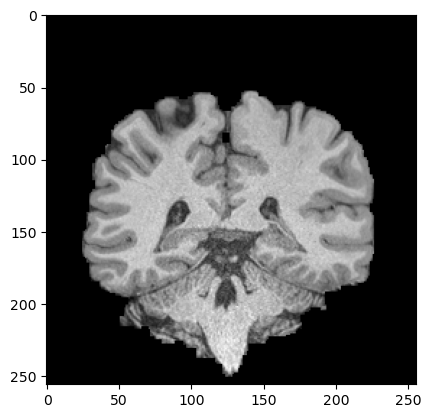

tensor(0.1249) tensor(0.1249)
False


In [18]:
image = img
mean =  271.648
std = 377.1171
image = (image - mean) / std
image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
print(image.shape)

#t = torch.randint(0, num_timesteps, (1,))
t=torch.tensor(0)
print(t)
noisy_pred = q_sample(image, t)
print(noisy_pred.shape)

plt.imshow(np.rot90(noisy_pred[0][0].numpy()),cmap='gray')
plt.show()
plt.imshow(np.rot90(image[0][0]),cmap='gray')
plt.show()

print(noisy_pred.mean(), image.mean())
print(image == noisy_pred[0][0].numpy())

In [124]:
# t : 600 with uniform sampling
# t : 600 with priorty sampling
# untet disriminator

In [154]:
# Assuming `num_timesteps` is defined in your code as the total number of timesteps
# Calculate priority sampling probabilities
num_timesteps = 100
cumulative_timesteps = torch.cumsum(torch.arange(1, num_timesteps + 1, dtype=torch.float32), dim=0)
priority_probs = torch.arange(1, num_timesteps + 1, dtype=torch.float32) / cumulative_timesteps[-1]

# Sample timesteps for each item in the batch based on priority distribution
t = torch.multinomial(priority_probs, 4, replacement=True).to(device)

#calculate the probability of each timestep
print(priority_probs)
timestep_probs = priority_probs[t] 
print(timestep_probs)

tensor([0.0002, 0.0004, 0.0006, 0.0008, 0.0010, 0.0012, 0.0014, 0.0016, 0.0018,
        0.0020, 0.0022, 0.0024, 0.0026, 0.0028, 0.0030, 0.0032, 0.0034, 0.0036,
        0.0038, 0.0040, 0.0042, 0.0044, 0.0046, 0.0048, 0.0050, 0.0051, 0.0053,
        0.0055, 0.0057, 0.0059, 0.0061, 0.0063, 0.0065, 0.0067, 0.0069, 0.0071,
        0.0073, 0.0075, 0.0077, 0.0079, 0.0081, 0.0083, 0.0085, 0.0087, 0.0089,
        0.0091, 0.0093, 0.0095, 0.0097, 0.0099, 0.0101, 0.0103, 0.0105, 0.0107,
        0.0109, 0.0111, 0.0113, 0.0115, 0.0117, 0.0119, 0.0121, 0.0123, 0.0125,
        0.0127, 0.0129, 0.0131, 0.0133, 0.0135, 0.0137, 0.0139, 0.0141, 0.0143,
        0.0145, 0.0147, 0.0149, 0.0150, 0.0152, 0.0154, 0.0156, 0.0158, 0.0160,
        0.0162, 0.0164, 0.0166, 0.0168, 0.0170, 0.0172, 0.0174, 0.0176, 0.0178,
        0.0180, 0.0182, 0.0184, 0.0186, 0.0188, 0.0190, 0.0192, 0.0194, 0.0196,
        0.0198])
tensor([0.0164, 0.0172, 0.0184, 0.0192])


In [19]:
from model3d import Discriminator

sr_slice = torch.rand(4,1,32,32,32).to(device)
disc = Discriminator(1).to(device)
disc_sr = disc(sr_slice)

TypeError: forward() missing 1 required positional argument: 't'